In [1]:
#ScoreCard IFS HRES IFS ENS MEAN
#Fuxi vs ENS Mean some of the better models up to lag 40, 64x32
#Fuxi initial conditions were ERA5, wheras ENS mean were Analysis/Operational
import os
import weatherbench2
import xarray as xr
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython
import matplotlib.pyplot  as plt
import tqdm
#mport Functions as fu
import line_profiler
from datetime import datetime, timedelta
from multiprocessing import Pool, cpu_count
import time
from weatherbench2.metrics import MSE, ACC
from weatherbench2.regions import SliceRegion



In [2]:
import apache_beam

In [3]:
xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative.zarr')

<xarray.Dataset>
Dimensions:                   (time: 3652, number: 50,
                               prediction_timedelta: 61, longitude: 64,
                               latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * number                    (number) int32 1 2 3 4 5 6 7 ... 45 46 47 48 49 50
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>

In [4]:
xr.open_zarr('gs://weatherbench2/datasets/neuralgcm_ens/2020-64x32_equiangular_conservative.zarr')

<xarray.Dataset>
Dimensions:                              (realization: 50, time: 732,
                                          prediction_timedelta: 32, level: 37,
                                          longitude: 64, latitude: 32)
Coordinates:
  * latitude                             (latitude) float64 -87.19 ... 87.19
  * level                                (level) int64 1 2 3 5 ... 950 975 1000
  * longitude                            (longitude) float64 0.0 5.625 ... 354.4
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] ...
  * realization                          (realization) int64 0 1 2 ... 47 48 49
  * time                                 (time) datetime64[ns] 2020-01-01 ......
Data variables:
    geopotential                         (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    specific_cloud_ice_water_content     (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    specific_cloud_liquid_water_content  (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    specific_humidity                    (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    temperature                          (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind                  (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    v_component_of_wind                  (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    wind_speed                           (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
Attributes:
    experiment_id:  73974210
    worker_id:      3

In [5]:
obs_path = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr'

In [6]:
pathsIFS = config.Paths(
    forecast='gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative.zarr',
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)

In [7]:

pathsgcm = config.Paths(
    forecast='gs://weatherbench2/datasets/neuralgcm_ens/2020-64x32_equiangular_conservative.zarr',
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)

In [8]:

startdate = {0:'2020-01-01',1:'2020-02-01',2:'2020-03-01',3:'2020-04-01',4:'2020-05-01',5:'2020-06-01',6:'2020-07-01',7:'2020-08-01',8:'2020-09-01',9:'2020-10-01',10:'2020-11-01',11:'2020-12-01'}
enddate = {0:'2020-01-03',1:'2020-02-03',2:'2020-03-03',3:'2020-04-03',4:'2020-05-03',5:'2020-06-03',6:'2020-07-03',7:'2020-08-03',8:'2020-09-03',9:'2020-10-03',10:'2020-11-03',11:'2020-12-03'}

In [9]:

from weatherbench2.metrics import CRPS, CRPSSpread, CRPSSkill, EnergyScore
from weatherbench2.regions import SliceRegion


pathsgcm = config.Paths(
    forecast='gs://weatherbench2/datasets/neuralgcm_ens/2020-64x32_equiangular_conservative.zarr',
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)

regions = {
    'northernhemisphere': SliceRegion(lat_slice=slice(20, 90)),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'southernhemisphere': SliceRegion(lat_slice=slice(-90, -20)),
}


for i in range(12):
    eval_configs = {
    'ENSERAmonthsgcm'+str(i): config.Eval(
        metrics={
            'CRPS': CRPS(), 
            'CRPSSpread': CRPSSpread(),
            'CRPSSkill': CRPSSkill(),
            'EnergyScore': EnergyScore()
        },
        regions=regions
    )
    }

    selection = config.Selection(
    variables=[
        'geopotential',
        'temperature',
        'u_component_of_wind',
        'v_component_of_wind',
    ],
    levels=[500, 850],
    time_slice=slice(startdate[i], enddate[i])
    )
    data_config = config.Data(selection=selection, paths=pathsgcm)

    evaluate_in_memory(data_config, eval_configs) 

c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\dask\array\core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\dask\array\core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\dask\array\core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\dask\array\core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\dask\array\core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\dask\array\core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
c:\Users\arche\a

In [14]:

from weatherbench2.metrics import CRPS, CRPSSpread, CRPSSkill, EnergyScore
from weatherbench2.regions import SliceRegion


pathsIFS = config.Paths(
    forecast='gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative.zarr',
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)
regions = {
    'northernhemisphere': SliceRegion(lat_slice=slice(20, 90)),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'southernhemisphere': SliceRegion(lat_slice=slice(-90, -20)),
}


for i in range(12):
    eval_configs = {
    'ENSERAmonths'+str(i): config.Eval(
        metrics={
            'CRPS': CRPS(), 
            'CRPSSpread': CRPSSpread(),
            'CRPSSkill': CRPSSkill(),
            'EnergyScore': EnergyScore()
        },
        regions=regions
    )
    }

    selection = config.Selection(
    variables=[
        'geopotential',
        'temperature',
        'u_component_of_wind',
        'v_component_of_wind',
    ],
    levels=[500, 850],
    time_slice=slice(startdate[i], enddate[i])
    )
    data_config = config.Data(selection=selection, paths=pathsIFS)
    
    evaluate_in_memory(data_config, eval_configs) 

c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\dask\array\core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\dask\array\core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\dask\array\core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\dask\array\core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\dask\array\core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\dask\array\core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
c:\Users\arche\a

In [3]:
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
observationsera = xr.open_zarr(obs_path)
observationsera

<xarray.Dataset>
Dimensions:                                           (time: 92044,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -87....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

In [10]:
observationsanalysis = xr.open_zarr('gs://weatherbench2/datasets/neuralgcm_ens/2020-64x32_equiangular_conservative.zarr')
observationsanalysis

<xarray.Dataset>
Dimensions:                              (realization: 50, time: 732,
                                          prediction_timedelta: 32, level: 37,
                                          longitude: 64, latitude: 32)
Coordinates:
  * latitude                             (latitude) float64 -87.19 ... 87.19
  * level                                (level) int64 1 2 3 5 ... 950 975 1000
  * longitude                            (longitude) float64 0.0 5.625 ... 354.4
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] ...
  * realization                          (realization) int64 0 1 2 ... 47 48 49
  * time                                 (time) datetime64[ns] 2020-01-01 ......
Data variables:
    geopotential                         (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    specific_cloud_ice_water_content     (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    specific_cloud_liquid_water_content  (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    specific_humidity                    (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    temperature                          (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind                  (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    v_component_of_wind                  (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    wind_speed                           (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
Attributes:
    experiment_id:  73974210
    worker_id:      3

In [5]:
climatology_path = 'gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_64x32_equiangular_conservative.zarr'
climatology = xr.open_zarr(climatology_path)
climatology

<xarray.Dataset>
Dimensions:                                         (hour: 4, dayofyear: 366,
                                                     longitude: 64,
                                                     latitude: 32, level: 13)
Coordinates:
  * dayofyear                                       (dayofyear) int64 1 ... 366
  * hour                                            (hour) int64 0 6 12 18
  * latitude                                        (latitude) float64 -87.19...
  * level                                           (level) int64 50 ... 1000
  * longitude                                       (longitude) float64 0.0 ....
Data variables: (12/53)
    10m_u_component_of_wind                         (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                         (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    10m_wind_speed                                  (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    2m_dewpoint_temperature                         (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    2m_temperature                                  (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    above_ground                                    (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    ...                                              ...
    volumetric_soil_water_layer_1                   (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_2                   (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_3                   (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_4                   (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    vorticity                                       (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    wind_speed                                      (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>

In [6]:
#IFS ENS mean
forecast2 = xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative_mean.zarr')
forecast2
#12 Hour increments, pred 6 Hours #61

<xarray.Dataset>
Dimensions:                   (time: 3652, prediction_timedelta: 61,
                               longitude: 64, latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>

In [7]:
#Fuxi
forecast11 = xr.open_zarr('gs://weatherbench2/datasets/fuxi/2020-64x32_equiangular_conservative.zarr')
forecast11
#12 Hour increments, pred 6 Hours #60, no time 0

<xarray.Dataset>
Dimensions:                            (time: 702, prediction_timedelta: 60,
                                        longitude: 64, latitude: 32, level: 2)
Coordinates:
  * latitude                           (latitude) float64 -87.19 ... 87.19
  * level                              (level) int32 500 850
  * longitude                          (longitude) float64 0.0 5.625 ... 354.4
  * prediction_timedelta               (prediction_timedelta) timedelta64[ns] ...
  * time                               (time) datetime64[ns] 2020-01-01 ... 2...
Data variables:
    10m_u_component_of_wind            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    10m_wind_speed                     (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    2m_temperature                     (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    geopotential                       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    temperature                        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    total_precipitation_24hr_from_6hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    total_precipitation_6hr            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    u_component_of_wind                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    v_component_of_wind                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    wind_speed                         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>

In [8]:
forecast11['10m_wind_speed'].sel(time = slice('2020-01-01', '2020-01-3')) #Slices go to end of day <-6 time slices

<xarray.DataArray '10m_wind_speed' (time: 6, prediction_timedelta: 60,
                                    longitude: 64, latitude: 32)>
dask.array<getitem, shape=(6, 60, 64, 32), dtype=float32, chunksize=(4, 60, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 0 days 06:00...
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-01-03T12:...

In [9]:
pathsIFS = config.Paths(
    forecast='gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative_mean.zarr',
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)
pathsIFUXI = config.Paths(
    forecast='gs://weatherbench2/datasets/fuxi/2020-64x32_equiangular_conservative.zarr',
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)

In [10]:
startdate = {0:'2020-01-01',1:'2020-02-01',2:'2020-03-01',3:'2020-04-01',4:'2020-05-01',5:'2020-06-01',6:'2020-07-01',7:'2020-08-01',8:'2020-09-01',9:'2020-10-01',10:'2020-11-01',11:'2020-12-01'}
enddate = {0:'2020-01-03',1:'2020-02-03',2:'2020-03-03',3:'2020-04-03',4:'2020-05-03',5:'2020-06-03',6:'2020-07-03',7:'2020-08-03',8:'2020-09-03',9:'2020-10-03',10:'2020-11-03',11:'2020-12-03'}

In [11]:
from weatherbench2.metrics import MSE, ACC
from weatherbench2.regions import SliceRegion

pathsIFS = config.Paths(
    forecast='gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative_mean.zarr',
    obs=obs_path,
    output_dir='./IFSCard',   # Directory to save evaluation results
)

regions = {
    'northernhemisphere': SliceRegion(lat_slice=slice(20, 90)),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'southernhemisphere': SliceRegion(lat_slice=slice(-90, -20)),
}


for i in range(12):
    eval_configs = {
    'ENSERAmonths'+str(i): config.Eval(
        metrics={
            'mse': MSE(), 
            'acc': ACC(climatology=climatology) 
        },
        regions=regions
    )
    }

    selection = config.Selection(
    variables=[
        'geopotential',
        'temperature',
        '2m_temperature',
        '10m_wind_speed',
    ],
    levels=[500, 850],
    time_slice=slice(startdate[i], enddate[i])
    )
    data_config = config.Data(selection=selection, paths=pathsIFS)
    
    evaluate_in_memory(data_config, eval_configs) 


KeyboardInterrupt: 

In [132]:
pathsIFS = config.Paths(
    forecast='gs://weatherbench2/datasets/fuxi/2020-64x32_equiangular_conservative.zarr',
    obs=obs_path,
    output_dir='./FUXICard',   # Directory to save evaluation results
)

regions = {
    'northernhemisphere': SliceRegion(lat_slice=slice(20, 90)),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'southernhemisphere': SliceRegion(lat_slice=slice(-90, -20)),
}


for i in range(12):
    eval_configs = {
    'FUXImonths'+str(i): config.Eval(
        metrics={
            'mse': MSE(), 
            'acc': ACC(climatology=climatology) 
        },
        regions=regions
    )
    }

    selection = config.Selection(
    variables=[
        'geopotential',
        'temperature',
        '2m_temperature',
        '10m_wind_speed',
    ],
    levels=[500, 850],
    time_slice=slice(startdate[i], enddate[i])
    )
    data_config = config.Data(selection=selection, paths=pathsIFS)
    
    evaluate_in_memory(data_config, eval_configs) 


In [9]:
overallIFSENSE = xr.open_dataset('./IFSCard/ENSERAmonths11.nc')
for i in range(11):
    results = xr.open_dataset('./IFSCard/ENSERAmonths' + str(i) + '.nc')
    overallIFSENSE = overallIFSENSE + results

overallIFSENSE = overallIFSENSE/12
overallIFSENSE = overallIFSENSE.isel(lead_time=slice(1, None))


In [10]:
overallFUXI = xr.open_dataset('./FUXICard/FUXImonths11.nc')
for i in range(11):
    results = xr.open_dataset('./FUXICard/FUXImonths' + str(i) + '.nc')
    overallFUXI = overallFUXI + results

overallFUXI = overallFUXI/12

In [12]:
overallIFSENSE

<xarray.Dataset>
Dimensions:         (lead_time: 60, region: 3, metric: 2, level: 2)
Coordinates:
  * lead_time       (lead_time) timedelta64[ns] 0 days 06:00:00 ... 15 days 0...
  * region          (region) object 'northernhemisphere' ... 'southernhemisph...
  * metric          (metric) object 'acc' 'mse'
  * level           (level) int32 500 850
Data variables:
    geopotential    (metric, region, lead_time, level) float64 0.9997 ... 4.8...
    temperature     (metric, region, lead_time, level) float64 0.9985 ... 13.86
    2m_temperature  (metric, region, lead_time) float64 0.9699 0.9569 ... 5.703
    10m_wind_speed  (metric, region, lead_time) float64 0.9916 0.9856 ... 7.083

In [135]:
overallFUXI

<xarray.Dataset>
Dimensions:         (lead_time: 60, region: 3, metric: 2, level: 2)
Coordinates:
  * lead_time       (lead_time) timedelta64[ns] 0 days 06:00:00 ... 15 days 0...
  * region          (region) object 'northernhemisphere' ... 'southernhemisph...
  * metric          (metric) object 'acc' 'mse'
  * level           (level) int32 500 850
Data variables:
    geopotential    (metric, region, lead_time, level) float64 0.9999 ... 4.7...
    temperature     (metric, region, lead_time, level) float64 0.9997 ... 14.65
    2m_temperature  (metric, region, lead_time) float64 0.9935 0.9922 ... 5.964
    10m_wind_speed  (metric, region, lead_time) float64 0.997 0.9903 ... 20.53

In [71]:
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns


# Assuming overallIFSENSE and overallFUXI are already loaded as xarray.Dataset
# Calculate the percentage difference: (FUXI - IFS ENS) / IFS ENS * 100
percentage_diff = (overallFUXI - overallIFSENSE) / overallIFSENSE * 100
print(percentage_diff)
geopotential = percentage_diff['geopotential'].values
geopotential.shape #now have normal array(metric =2, region =3, leadtime = 60, level =2)

<xarray.Dataset>
Dimensions:         (lead_time: 60, region: 3, metric: 2, level: 2)
Coordinates:
  * lead_time       (lead_time) timedelta64[ns] 0 days 06:00:00 ... 15 days 0...
  * region          (region) object 'northernhemisphere' ... 'southernhemisph...
  * metric          (metric) object 'acc' 'mse'
  * level           (level) int32 500 850
Data variables:
    geopotential    (metric, region, lead_time, level) float64 0.02242 ... -0...
    temperature     (metric, region, lead_time, level) float64 0.1149 ... 5.72
    2m_temperature  (metric, region, lead_time) float64 2.43 3.693 ... 4.582
    10m_wind_speed  (metric, region, lead_time) float64 0.5467 0.4789 ... 189.9


(2, 3, 60, 2)

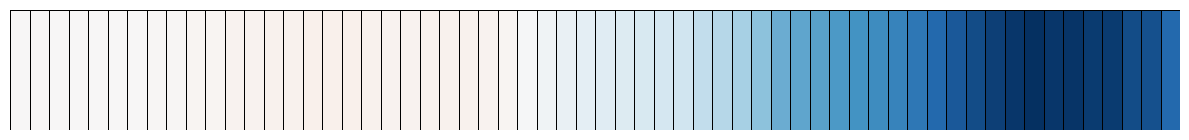

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract data (adjust indexing as needed)
geopotential_plot_data = geopotential[0, 0, :, 0]  # Shape: (lead_time,)

# Reshape data for heatmap (one row with multiple columns)
data_for_plot = geopotential_plot_data[np.newaxis, :]  # Shape: (1, lead_time)

# Plot setup
plt.figure(figsize=(12, 1.5))  # Wide and short to look like a scorecard

# Create a heatmap without axis tickmarks or color bar
sns.heatmap(
    data_for_plot,
    cmap='RdBu_r',
    center=0,
    linewidths=0.5,
    linecolor='black',
    cbar=False,  # No color bar for now
    xticklabels=False,  # Remove x-axis tickmarks
    yticklabels=False   # Remove y-axis tickmarks
)

# Remove axis labels and title for now
plt.xlabel('')
plt.ylabel('')
plt.title('')

# Adjust layout
plt.tight_layout()
plt.show()


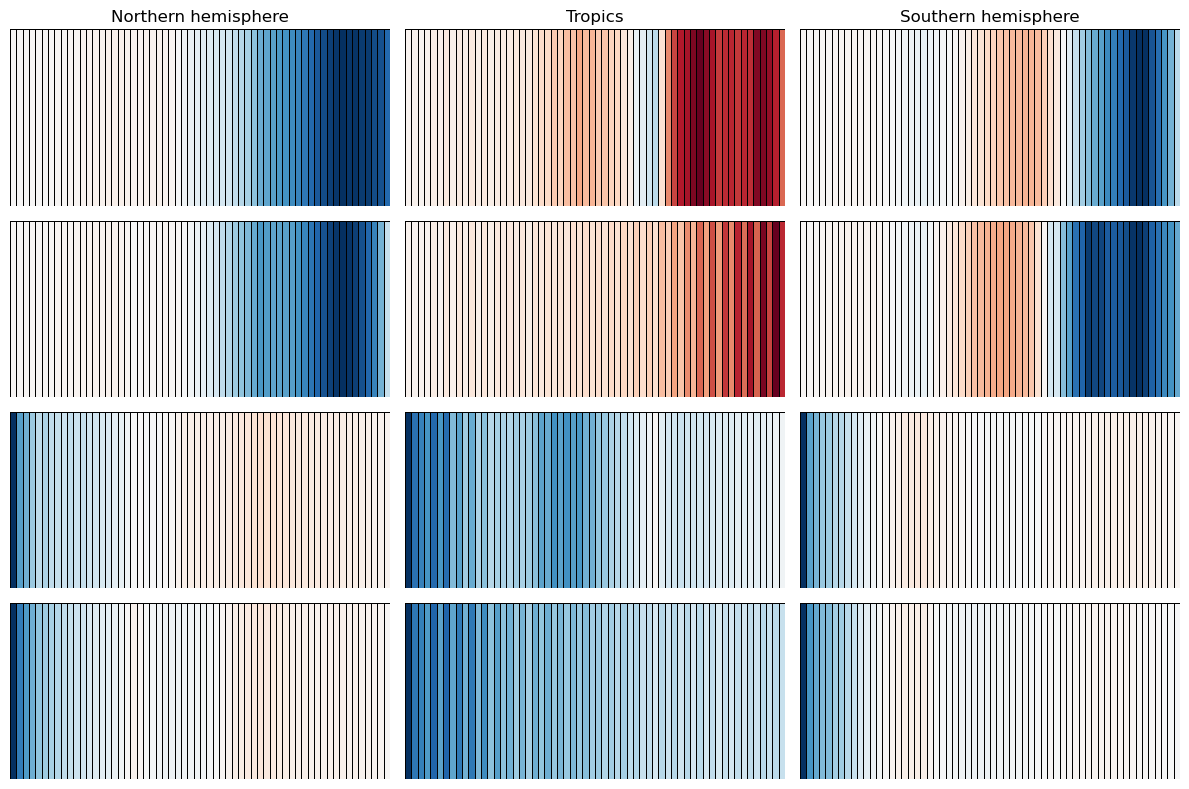

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract regions, metrics, and levels information
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']  # Replace with actual region names if available
metrics = ['acc', 'mse']  # Example metrics (adjust as needed)
levels = [500, 850]  # Example levels (adjust as needed)

# Set up the figure for a grid of subplots
fig, axes = plt.subplots(nrows=len(metrics) * len(levels), ncols=len(regions), figsize=(12, 8))

# Flatten axes for easier indexing if necessary
axes = axes.flatten() if len(metrics) * len(levels) > 1 else [axes]

# Loop over each region, metric, and level to generate heatmaps
for region_idx, region in enumerate(regions):
    for metric_idx, metric in enumerate(metrics):
        for level_idx, level in enumerate(levels):
            # Calculate the appropriate index for the subplot
            plot_idx = region_idx + (metric_idx * len(levels) + level_idx) * len(regions)
            
            # Extract data (adjust indexing as needed)
            geopotential_plot_data = geopotential[metric_idx, region_idx, :, level_idx]

            # Reshape data for heatmap
            data_for_plot = geopotential_plot_data[np.newaxis, :]

            # Select the axis for this plot
            ax = axes[plot_idx]

            # Create heatmap
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0.5,
                linecolor='black',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

            # Add title only to the top row
            if metric_idx == 0 and level_idx == 0:
                ax.set_title(f'{region.capitalize()}')

            # Remove axis labels
            ax.set_xlabel('')
            ax.set_ylabel('')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


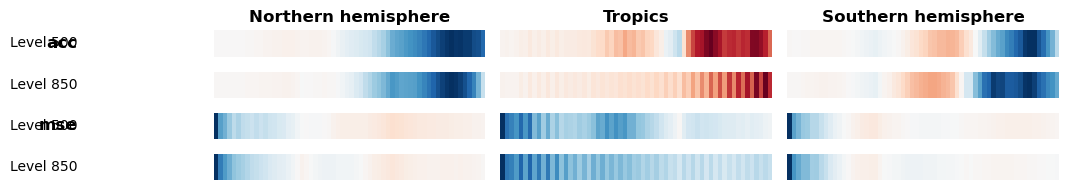

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data structure for regions, metrics, and levels
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']  # Replace with actual region names if available
metrics = ['acc', 'mse']  # Example metrics (adjust as needed)
levels = [500, 850]  # Pressure levels

# Set up the figure with appropriate size
fig, axes = plt.subplots(nrows=len(metrics) * len(levels), ncols=len(regions), figsize=(12, 2))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop over regions, metrics, and levels to generate heatmaps
for region_idx, region in enumerate(regions):
    for metric_idx, metric in enumerate(metrics):
        for level_idx, level in enumerate(levels):
            # Calculate the subplot index
            plot_idx = region_idx + (metric_idx * len(levels) + level_idx) * len(regions)

            # Extract data for the plot (adjust indexing as needed)
            geopotential_plot_data = geopotential[metric_idx, region_idx, :, level_idx]

            # Reshape for heatmap
            data_for_plot = geopotential_plot_data[np.newaxis, :]

            # Select the axis for this plot
            ax = axes[plot_idx]

            # Create heatmap
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                #linecolor='black',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

            # Add region name as title in the top row
            if metric_idx == 0 and level_idx == 0:
                ax.set_title(f'{region.capitalize()}', fontsize=12, fontweight='bold')

            # Add metric and level labels on the left
            if region_idx == 0:  # Add labels only for the first column
                if level_idx == 0:  # Metric label on the first level row
                    ax.annotate(metric, xy=(-0.5, 0.5), xycoords='axes fraction',
                                ha='right', va='center', fontsize=12, fontweight='bold', annotation_clip=False)

                # Level label on each row
                ax.annotate(f'Level {level}', xy=(-0.5, 0.5), xycoords='axes fraction',
                            ha='right', va='center', fontsize=10, annotation_clip=False)

            # Remove axis labels
            ax.set_xlabel('')
            ax.set_ylabel('')

# Adjust layout
plt.tight_layout(rect=[0.1, 0, 1, 1])  # Leave space on the left for labels
plt.show()


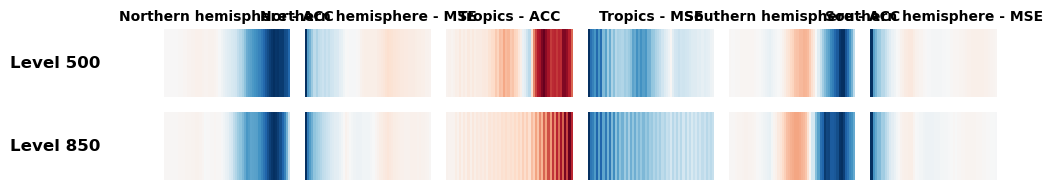

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data structure
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']  # Replace with actual region names
metrics = ['ACC', 'MSE']  # Example metrics
levels = [500, 850]  # Pressure levels

# Set up the figure with a new arrangement
fig, axes = plt.subplots(
    nrows=len(levels), ncols=len(regions) * len(metrics), figsize=(12, 2)
)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop over regions, metrics, and levels to generate heatmaps
for region_idx, region in enumerate(regions):
    for metric_idx, metric in enumerate(metrics):
        for level_idx, level in enumerate(levels):
            # Calculate the subplot index
            col_idx = region_idx * len(metrics) + metric_idx
            plot_idx = level_idx * (len(regions) * len(metrics)) + col_idx

            # Extract data for the plot (adjust indexing as needed)
            geopotential_plot_data = geopotential[metric_idx, region_idx, :, level_idx]

            # Reshape for heatmap
            data_for_plot = geopotential_plot_data[np.newaxis, :]

            # Select the axis for this plot
            ax = axes[plot_idx]

            # Create heatmap without box boundaries
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

            # Add region and metric titles in the top row
            if level_idx == 0:
                ax.set_title(f'{region.capitalize()} - {metric}', fontsize=10, fontweight='bold')

            # Add level labels on the leftmost column
            if col_idx == 0:
                ax.annotate(f'Level {level}', xy=(-0.5, 0.5), xycoords='axes fraction',
                            ha='right', va='center', fontsize=12, fontweight='bold', annotation_clip=False)

            # Remove axis labels
            ax.set_xlabel('')
            ax.set_ylabel('')

# Adjust layout for better spacing
plt.tight_layout(rect=[0.15, 0, 1, 1])  # Leave space on the left for level labels
plt.show()


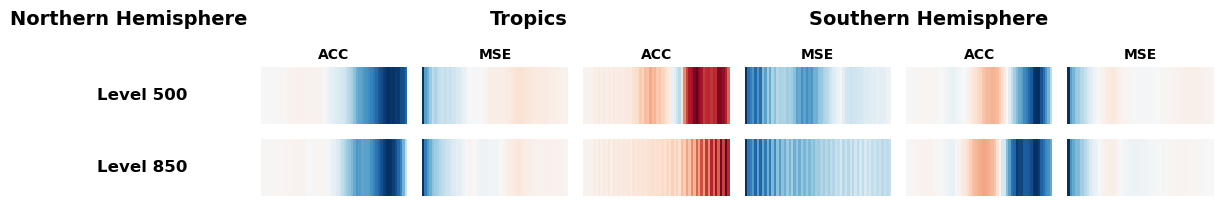

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data structure
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['ACC', 'MSE']
levels = [500, 850]

# Set up the figure with a new arrangement
fig, axes = plt.subplots(
    nrows=len(levels), ncols=len(regions) * len(metrics), figsize=(12, 2)
)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Add region titles spanning two columns each
for region_idx, region in enumerate(regions):
    col_start = region_idx * len(metrics)
    col_end = col_start + len(metrics)
    fig.text(
        (col_start + 0.5) / (len(regions) * len(metrics)), 0.96,  # Adjust y-position as needed
        region,
        ha='center', va='bottom', fontsize=14, fontweight='bold'
    )

# Loop over regions, metrics, and levels to generate heatmaps
for region_idx, region in enumerate(regions):
    for metric_idx, metric in enumerate(metrics):
        for level_idx, level in enumerate(levels):
            # Calculate subplot index
            col_idx = region_idx * len(metrics) + metric_idx
            plot_idx = level_idx * (len(regions) * len(metrics)) + col_idx

            # Extract data for the plot (adjust indexing as needed)
            geopotential_plot_data = geopotential[metric_idx, region_idx, :, level_idx]

            # Reshape for heatmap
            data_for_plot = geopotential_plot_data[np.newaxis, :]

            # Select the axis for this plot
            ax = axes[plot_idx]

            # Create heatmap without box boundaries
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

            # Add metric title for the first row of each column
            if level_idx == 0:
                ax.set_title(metric, fontsize=10, fontweight='bold')

            # Add level labels on the leftmost column
            if col_idx == 0:
                ax.annotate(f'Level {level}', xy=(-0.5, 0.5), xycoords='axes fraction',
                            ha='right', va='center', fontsize=12, fontweight='bold', annotation_clip=False)

            # Remove axis labels
            ax.set_xlabel('')
            ax.set_ylabel('')

# Adjust layout for better spacing
plt.tight_layout(rect=[0.05, 0.05, 1, 0.94])  # Adjust layout to make room for titles
plt.show()


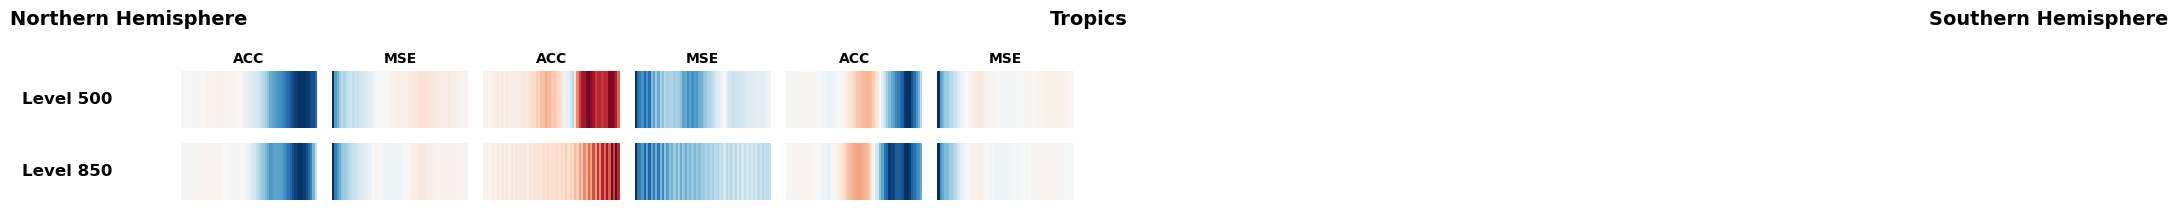

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data structure
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['ACC', 'MSE']
levels = [500, 850]

# Calculate number of columns and rows
n_cols = len(regions) * len(metrics)
n_rows = len(levels)

# Set up the figure with the new arrangement
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 2))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Add region labels centered over their metric columns
for region_idx, region in enumerate(regions):
    # Calculate the center position for the region label
    col_start = region_idx * len(metrics)
    col_end = col_start + len(metrics)
    region_center = (col_start + col_end - 1) / (n_cols - 1)

    # Add the region label
    fig.text(
        region_center, 0.98, region, ha='center', va='bottom', 
        fontsize=14, fontweight='bold'
    )

# Loop over regions, metrics, and levels to generate heatmaps
for region_idx, region in enumerate(regions):
    
    for metric_idx, metric in enumerate(metrics):
        for level_idx, level in enumerate(levels):
            # Calculate subplot index
            col_idx = region_idx * len(metrics) + metric_idx
            plot_idx = level_idx * n_cols + col_idx

            # Extract data for the plot (adjust indexing as needed)
            geopotential_plot_data = geopotential[metric_idx, region_idx, :, level_idx]

            # Reshape for heatmap
            data_for_plot = geopotential_plot_data[np.newaxis, :]

            # Select the axis for this plot
            ax = axes[plot_idx]

            # Create heatmap without box boundaries
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

            # Add metric title for the first row of each column
            if level_idx == 0:
                ax.set_title(metric, fontsize=10, fontweight='bold')

            # Add level labels on the leftmost column only
            if col_idx == 0:
                ax.annotate(f'Level {level}', xy=(-0.5, 0.5), xycoords='axes fraction',
                            ha='right', va='center', fontsize=12, fontweight='bold', annotation_clip=False)

            # Remove axis labels
            ax.set_xlabel('')
            ax.set_ylabel('')

# Adjust layout to fit everything properly
plt.tight_layout(rect=[0.1, 0.05, 1, 0.94])  # Leave room at the top for titles
plt.show()


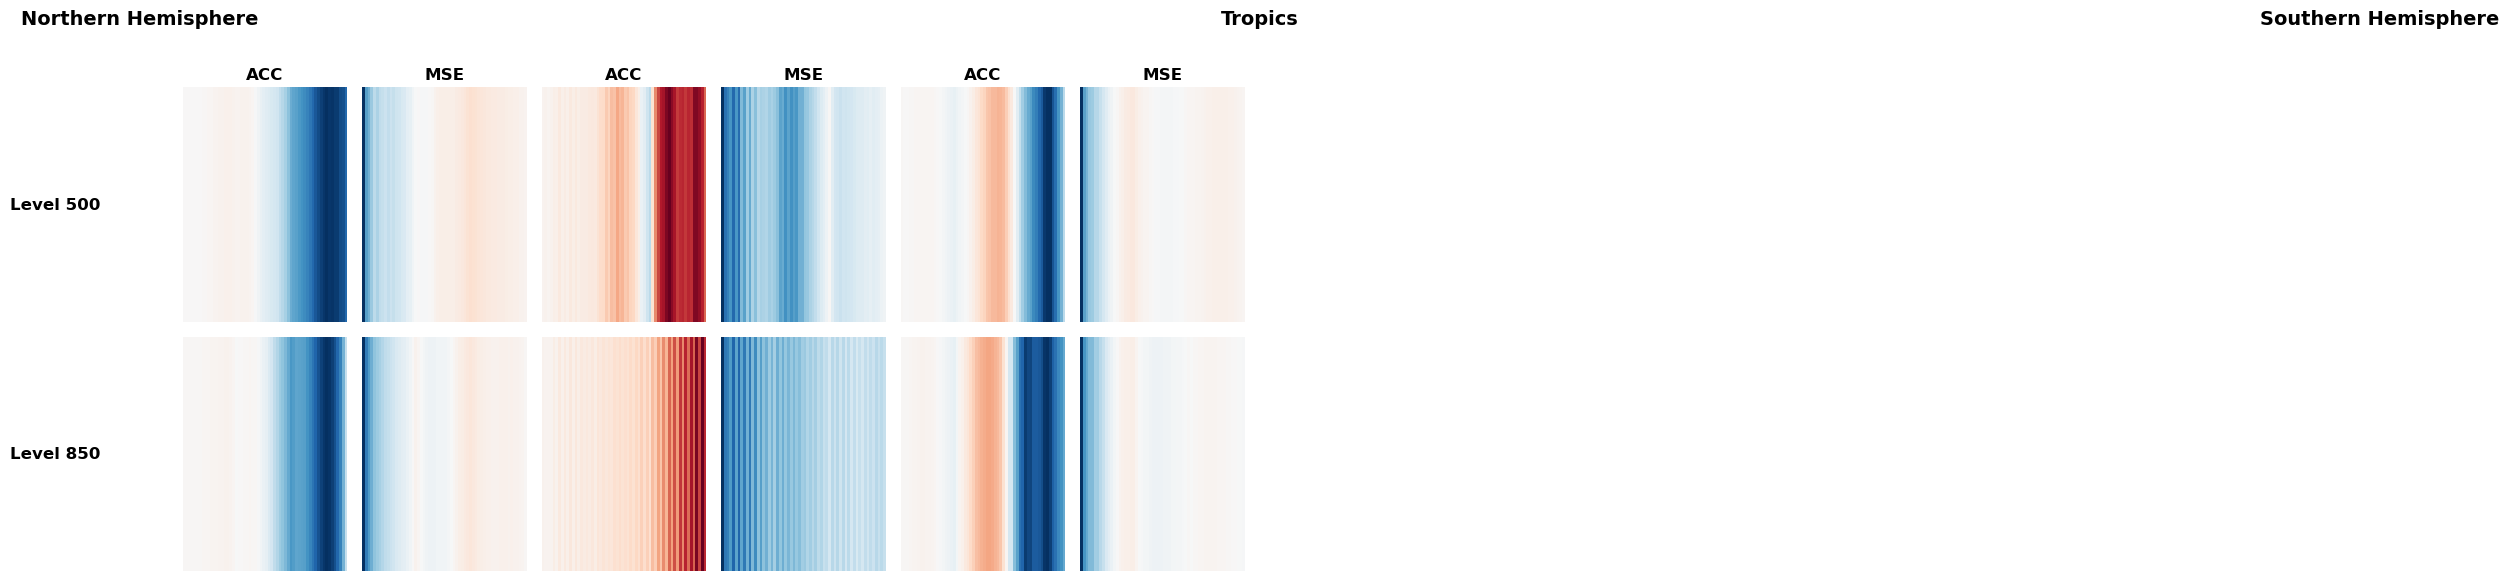

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data structure
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['ACC', 'MSE']
levels = [500, 850]

# Calculate the figure dimensions
n_metrics = len(metrics)
n_regions = len(regions)
n_levels = len(levels)

# Set up the figure with region columns and metric sub-columns
fig, axes = plt.subplots(nrows=n_levels, ncols=n_regions * n_metrics, figsize=(14, 6))

# Flatten axes array for easier indexing
axes = axes.flatten()

# === Add region titles ===
for region_idx, region in enumerate(regions):
    # Calculate the start and end positions for the region columns
    region_col_start = region_idx * n_metrics
    region_col_end = region_col_start + n_metrics

    # Center the region title above its corresponding columns
    region_center = (region_col_start + region_col_end - 1) / (n_regions * n_metrics - 1)

    # Add the region title
    fig.text(region_center, 0.98, region, ha='center', va='bottom', fontsize=14, fontweight='bold')

# === Loop over regions, metrics, and levels to generate heatmaps ===
for region_idx, region in enumerate(regions):
    for metric_idx, metric in enumerate(metrics):
        for level_idx, level in enumerate(levels):
            # Calculate subplot index
            col_idx = region_idx * n_metrics + metric_idx
            plot_idx = level_idx * (n_regions * n_metrics) + col_idx

            # Extract data for the plot (adjust indexing as needed)
            geopotential_plot_data = geopotential[metric_idx, region_idx, :, level_idx]

            # Reshape for heatmap
            data_for_plot = geopotential_plot_data[np.newaxis, :]

            # Select the axis for this plot
            ax = axes[plot_idx]

            # Create heatmap without box boundaries
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

            # === Add metric titles (on the first row) ===
            if level_idx == 0:
                ax.set_title(metric, fontsize=12, fontweight='bold')

            # === Add level labels on the leftmost column only ===
            if col_idx == 0:
                ax.annotate(f'Level {level}', xy=(-0.5, 0.5), xycoords='axes fraction',
                            ha='right', va='center', fontsize=12, fontweight='bold', annotation_clip=False)

            # Remove axis labels
            ax.set_xlabel('')
            ax.set_ylabel('')

# Adjust layout to fit everything properly
plt.tight_layout(rect=[0.1, 0.05, 1, 0.94])  # Leave room for titles at the top
plt.show()


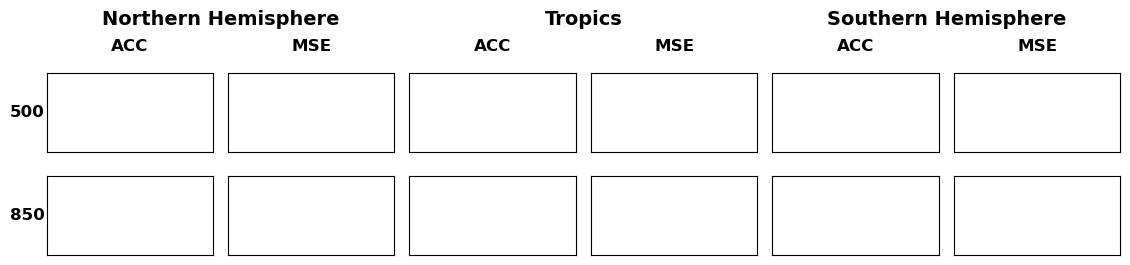

In [76]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Example data structure
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['ACC', 'MSE']
levels = [500, 850]

# Set up the figure and gridspec layout with smaller row heights
fig = plt.figure(figsize=(12, 3))
spec = gridspec.GridSpec(
    nrows=len(levels) + 2, 
    ncols=len(regions) * len(metrics), 
    figure=fig, 
    height_ratios=[-0.05, -0.05] + [1] * len(levels)  # Reduced header height ratios
)

# === Add region titles ===
for region_idx, region in enumerate(regions):
    region_start_col = region_idx * len(metrics)
    region_end_col = region_start_col + len(metrics)
    
    # Add region title centered above its two metric columns
    ax_region = fig.add_subplot(spec[0, region_start_col:region_end_col])
    ax_region.set_title(region, fontsize=14, fontweight='bold')
    ax_region.axis('off')  # Remove axis from region title box

# === Add metric titles ===
for region_idx in range(len(regions)):
    for metric_idx, metric in enumerate(metrics):
        col_idx = region_idx * len(metrics) + metric_idx

        # Add metric title above the respective column
        ax_metric = fig.add_subplot(spec[1, col_idx])
        ax_metric.set_title(metric, fontsize=12, verticalalignment = 'center_baseline', fontweight='bold')
        ax_metric.axis('off')  # Remove axis from metric title box

# === Create empty plots with level labels ===
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2, col_idx])

            # Add empty heatmap placeholder
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.patch.set_alpha(0.0)  # Transparent background for empty plot

    # Add level labels to the first metric column of each row
    ax_label = fig.add_subplot(spec[level_idx + 2, 0])
    ax_label.annotate(f'{level}', xy=(-0.01, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, fontweight='bold', annotation_clip=False)
    ax_label.axis('off')  # Remove axis from level label box

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Leave a bit of space for titles at the top
plt.show()


In [81]:
percentage_diff = (overallFUXI - overallIFSENSE) / overallIFSENSE * 100
print(percentage_diff)
geopotential = percentage_diff['geopotential'].values
geopotential.shape #now have normal array(metric =2, region =3, leadtime = 60, level =2)

temperature = percentage_diff['temperature'].values
m2_temperature = percentage_diff['2m_temperature'].values
m10_wind_speed = percentage_diff['10m_wind_speed'].values


<xarray.Dataset>
Dimensions:         (lead_time: 60, region: 3, metric: 2, level: 2)
Coordinates:
  * lead_time       (lead_time) timedelta64[ns] 0 days 06:00:00 ... 15 days 0...
  * region          (region) object 'northernhemisphere' ... 'southernhemisph...
  * metric          (metric) object 'acc' 'mse'
  * level           (level) int32 500 850
Data variables:
    geopotential    (metric, region, lead_time, level) float64 0.02242 ... -0...
    temperature     (metric, region, lead_time, level) float64 0.1149 ... 5.72
    2m_temperature  (metric, region, lead_time) float64 2.43 3.693 ... 4.582
    10m_wind_speed  (metric, region, lead_time) float64 0.5467 0.4789 ... 189.9


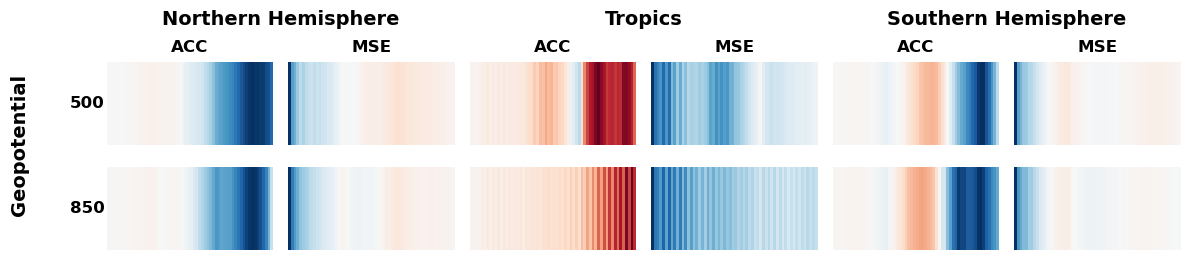

In [83]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Example data structure
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['ACC', 'MSE']
levels = [500, 850]

# Set up the figure and gridspec layout with smaller row heights
fig = plt.figure(figsize=(12, 3))
spec = gridspec.GridSpec(
    nrows=len(levels) + 2, 
    ncols=len(regions) * len(metrics), 
    figure=fig, 
    height_ratios=[-0.1, -0.1] + [1] * len(levels)  # Adjust header height ratios
)

# === Add region titles ===
for region_idx, region in enumerate(regions):
    region_start_col = region_idx * len(metrics)
    region_end_col = region_start_col + len(metrics)

    # Add region title centered above its two metric columns
    ax_region = fig.add_subplot(spec[0, region_start_col:region_end_col])
    ax_region.set_title(region, fontsize=14, fontweight='bold')
    ax_region.axis('off')  # Remove axis from region title box

# === Add metric titles with lowered position ===
for region_idx in range(len(regions)):
    for metric_idx, metric in enumerate(metrics):
        col_idx = region_idx * len(metrics) + metric_idx

        # Add the metric title manually with lowered vertical position
        ax_metric = fig.add_subplot(spec[1, col_idx])
        ax_metric.text(0.5, 1, metric, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax_metric.transAxes)
        ax_metric.axis('off')  # Remove axis from metric title box

fig.text(0.02, 0.45, 'Geopotential', ha='center', va='center', fontsize=14, fontweight='bold', rotation='vertical')


# === Create empty plots with level labels ===
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2, col_idx])
            
            geopotential_plot_data = geopotential[metric_idx, region_idx, :, level_idx]

            data_for_plot = geopotential_plot_data[np.newaxis, :]
            # Create heatmap without box boundaries
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            ) # Transparent background for empty plot

    # Add level labels to the first metric column of each row
    ax_label = fig.add_subplot(spec[level_idx + 2, 0])
    ax_label.annotate(f'{level}', xy=(-0.01, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, fontweight='bold', annotation_clip=False)
    ax_label.axis('off')  # Remove axis from level label box

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Leave a bit of space for titles at the top
plt.show()

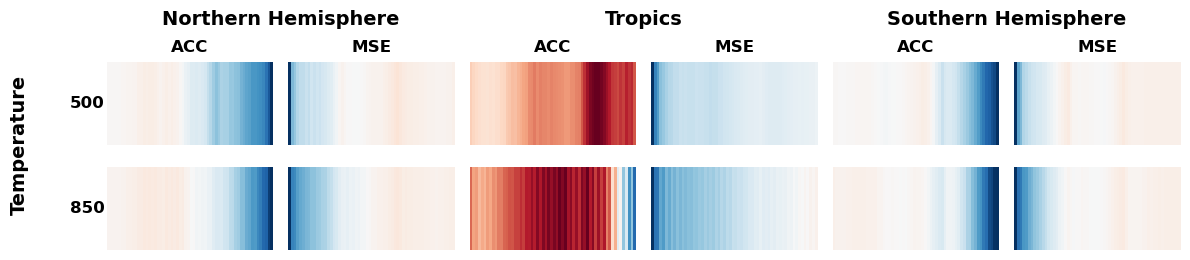

In [88]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Example data structure
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['ACC', 'MSE']
levels = [500, 850]

# Set up the figure and gridspec layout with smaller row heights
fig = plt.figure(figsize=(12, 3))
spec = gridspec.GridSpec(
    nrows=len(levels) + 2, 
    ncols=len(regions) * len(metrics), 
    figure=fig, 
    height_ratios=[-0.1, -0.1] + [1] * len(levels)  # Adjust header height ratios
)

# === Add region titles ===
for region_idx, region in enumerate(regions):
    region_start_col = region_idx * len(metrics)
    region_end_col = region_start_col + len(metrics)

    # Add region title centered above its two metric columns
    ax_region = fig.add_subplot(spec[0, region_start_col:region_end_col])
    ax_region.set_title(region, fontsize=14, fontweight='bold')
    ax_region.axis('off')  # Remove axis from region title box

# === Add metric titles with lowered position ===
for region_idx in range(len(regions)):
    for metric_idx, metric in enumerate(metrics):
        col_idx = region_idx * len(metrics) + metric_idx

        # Add the metric title manually with lowered vertical position
        ax_metric = fig.add_subplot(spec[1, col_idx])
        ax_metric.text(0.5, 1, metric, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax_metric.transAxes)
        ax_metric.axis('off')  # Remove axis from metric title box

fig.text(0.02, 0.45, 'Temperature', ha='center', va='center', fontsize=14, fontweight='bold', rotation='vertical')


# === Create empty plots with level labels ===
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2, col_idx])
            
            geopotential_plot_data = temperature[metric_idx, region_idx, :, level_idx]

            data_for_plot = geopotential_plot_data[np.newaxis, :]
            # Create heatmap without box boundaries
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            ) # Transparent background for empty plot

    # Add level labels to the first metric column of each row
    ax_label = fig.add_subplot(spec[level_idx + 2, 0])
    ax_label.annotate(f'{level}', xy=(-0.01, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, fontweight='bold', annotation_clip=False)
    ax_label.axis('off')  # Remove axis from level label box

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Leave a bit of space for titles at the top
plt.show()

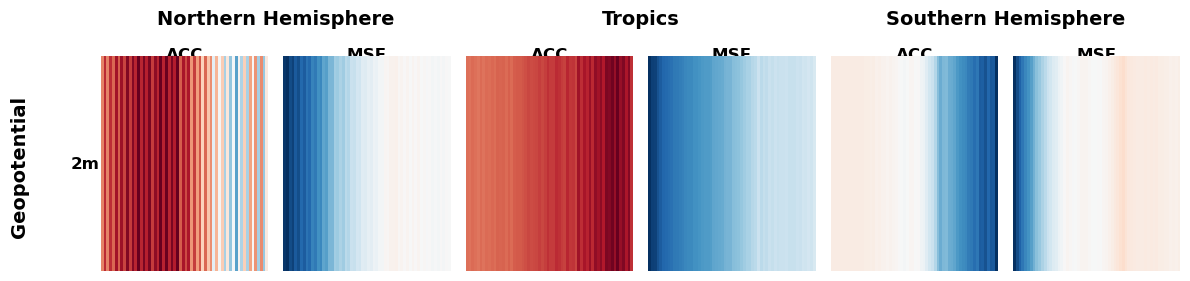

In [89]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Example data structure
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['ACC', 'MSE']
levels = ['2m']

# Set up the figure and gridspec layout with smaller row heights
fig = plt.figure(figsize=(12, 3))
spec = gridspec.GridSpec(
    nrows=len(levels) + 2, 
    ncols=len(regions) * len(metrics), 
    figure=fig, 
    height_ratios=[-0.1, -0.1] + [1] * len(levels)  # Adjust header height ratios
)

# === Add region titles ===
for region_idx, region in enumerate(regions):
    region_start_col = region_idx * len(metrics)
    region_end_col = region_start_col + len(metrics)

    # Add region title centered above its two metric columns
    ax_region = fig.add_subplot(spec[0, region_start_col:region_end_col])
    ax_region.set_title(region, fontsize=14, fontweight='bold')
    ax_region.axis('off')  # Remove axis from region title box

# === Add metric titles with lowered position ===
for region_idx in range(len(regions)):
    for metric_idx, metric in enumerate(metrics):
        col_idx = region_idx * len(metrics) + metric_idx

        # Add the metric title manually with lowered vertical position
        ax_metric = fig.add_subplot(spec[1, col_idx])
        ax_metric.text(0.5, 1, metric, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax_metric.transAxes)
        ax_metric.axis('off')  # Remove axis from metric title box

fig.text(0.02, 0.45, 'Geopotential', ha='center', va='center', fontsize=14, fontweight='bold', rotation='vertical')


# === Create empty plots with level labels ===
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2, col_idx])
            
            geopotential_plot_data = m2_temperature[metric_idx, region_idx, :]

            data_for_plot = geopotential_plot_data[np.newaxis, :]
            # Create heatmap without box boundaries
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            ) # Transparent background for empty plot

    # Add level labels to the first metric column of each row
    ax_label = fig.add_subplot(spec[level_idx + 2, 0])
    ax_label.annotate(f'{level}', xy=(-0.01, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, fontweight='bold', annotation_clip=False)
    ax_label.axis('off')  # Remove axis from level label box

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Leave a bit of space for titles at the top
plt.show()

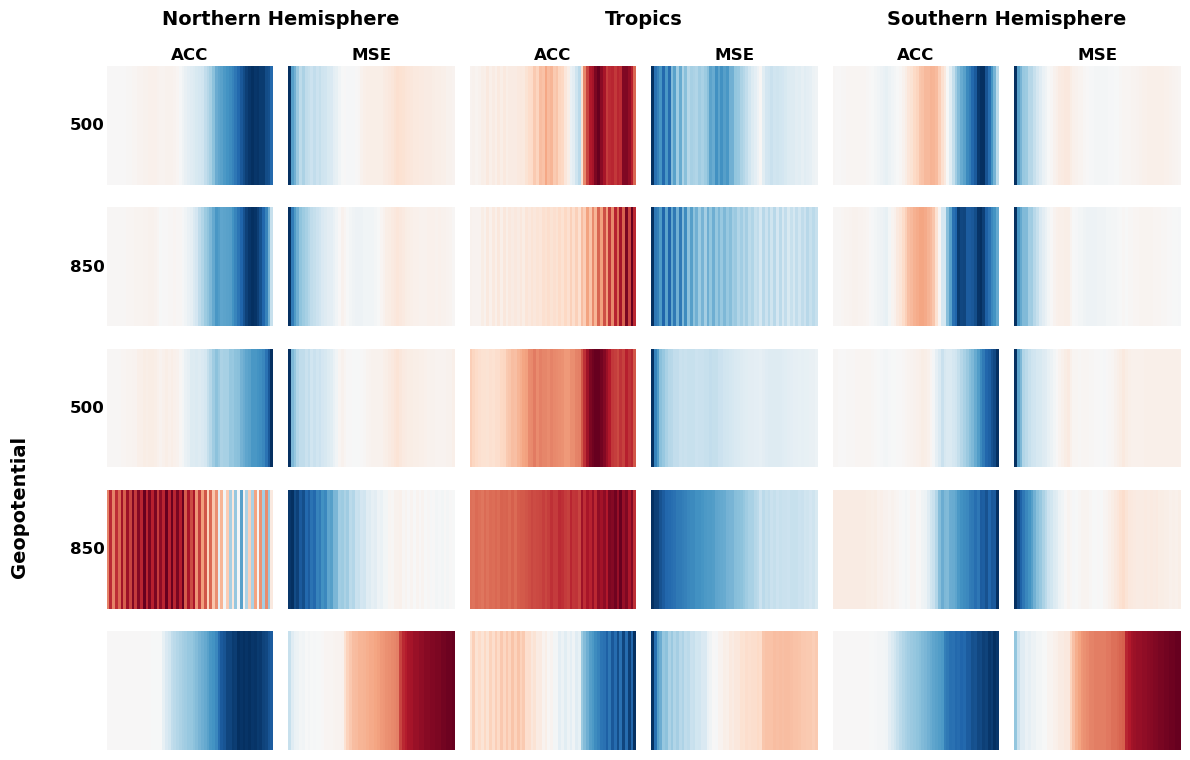

In [86]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns

# Example data structure
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['ACC', 'MSE']
levels = [500, 850]

# Set up the figure and gridspec layout with smaller row heights
fig = plt.figure(figsize=(12, 10))  # Increased figure height to accommodate more rows
spec = gridspec.GridSpec(
    nrows=len(levels) + 2 + 4,  # Added 3 more rows for temperature, 2m_temperature, and 10m_wind speed
    ncols=len(regions) * len(metrics), 
    figure=fig, 
    height_ratios=[-0.1, -0.1] + [1] * len(levels) + [1, 1, 1,1]  # Adjust header height ratios and add more rows
)

# === Add region titles ===
for region_idx, region in enumerate(regions):
    region_start_col = region_idx * len(metrics)
    region_end_col = region_start_col + len(metrics)

    # Add region title centered above its two metric columns
    ax_region = fig.add_subplot(spec[0, region_start_col:region_end_col])
    ax_region.set_title(region, fontsize=14, fontweight='bold')
    ax_region.axis('off')  # Remove axis from region title box

# === Add metric titles with lowered position ===
for region_idx in range(len(regions)):
    for metric_idx, metric in enumerate(metrics):
        col_idx = region_idx * len(metrics) + metric_idx

        # Add the metric title manually with lowered vertical position
        ax_metric = fig.add_subplot(spec[1, col_idx])
        ax_metric.text(0.5, 1, metric, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax_metric.transAxes)
        ax_metric.axis('off')  # Remove axis from metric title box

fig.text(0.02, 0.45, 'Geopotential', ha='center', va='center', fontsize=14, fontweight='bold', rotation='vertical')

# === Create empty plots with level labels ===
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2, col_idx])
            
            geopotential_plot_data = geopotential[metric_idx, region_idx, :, level_idx]

            data_for_plot = geopotential_plot_data[np.newaxis, :]
            # Create heatmap without box boundaries
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            ) # Transparent background for empty plot

    # Add level labels to the first metric column of each row
    ax_label = fig.add_subplot(spec[level_idx + 2, 0])
    ax_label.annotate(f'{level}', xy=(-0.01, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, fontweight='bold', annotation_clip=False)
    ax_label.axis('off')  # Remove axis from level label box

# === Plot temperature data ===
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2 + len(levels), col_idx])
            
            temperature_plot_data = temperature[metric_idx, region_idx, :, level_idx]

            data_for_plot = temperature_plot_data[np.newaxis, :]
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

    # Add level labels to the first metric column of each row
    ax_label = fig.add_subplot(spec[level_idx + 2 + len(levels), 0])
    ax_label.annotate(f'{level}', xy=(-0.01, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, fontweight='bold', annotation_clip=False)
    ax_label.axis('off')  # Remove axis from level label box

# === Plot 2m_temperature data ===
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) + 2 + 1, col_idx])
        
        temperature_2m_plot_data = m2_temperature[metric_idx, region_idx, :]

        data_for_plot = temperature_2m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap='RdBu_r',
            center=0,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )

# === Plot 10m_wind speed data ===
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) + 2 + 2, col_idx])
        
        wind_speed_10m_plot_data = m10_wind_speed[metric_idx, region_idx, :]

        data_for_plot = wind_speed_10m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap='RdBu_r',
            center=0,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Leave a bit of space for titles at the top
plt.show()

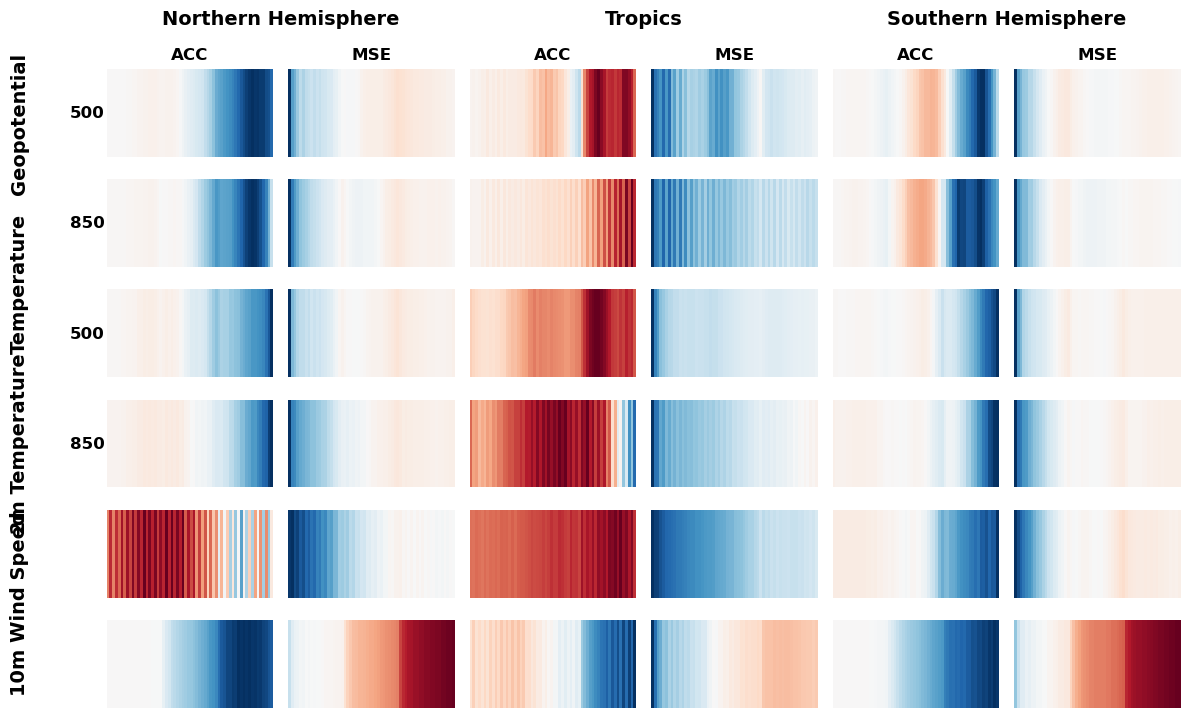

In [92]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns

# Example data structure
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['ACC', 'MSE']
levels = [500, 850]

# Set up the figure and gridspec layout
fig = plt.figure(figsize=(12, 8))  # Increased figure height to accommodate 6 rows
spec = gridspec.GridSpec(
    nrows=2 + len(levels) * 2 + 2,  # 2 header rows + 2 levels for geopotential + 2 levels for temperature + 2 rows for 2m_temperature and 10m_wind speed
    ncols=len(regions) * len(metrics), 
    figure=fig, 
    height_ratios=[-0.1, -0.1] + [1] * (len(levels) * 2) + [1, 1]  # Adjust header height ratios and add more rows
)

# === Add region titles ===
for region_idx, region in enumerate(regions):
    region_start_col = region_idx * len(metrics)
    region_end_col = region_start_col + len(metrics)

    # Add region title centered above its two metric columns
    ax_region = fig.add_subplot(spec[0, region_start_col:region_end_col])
    ax_region.set_title(region, fontsize=14, fontweight='bold')
    ax_region.axis('off')  # Remove axis from region title box

# === Add metric titles with lowered position ===
for region_idx in range(len(regions)):
    for metric_idx, metric in enumerate(metrics):
        col_idx = region_idx * len(metrics) + metric_idx

        # Add the metric title manually with lowered vertical position
        ax_metric = fig.add_subplot(spec[1, col_idx])
        ax_metric.text(0.5, 1, metric, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax_metric.transAxes)
        ax_metric.axis('off')  # Remove axis from metric title box

# === Plot geopotential data ===
fig.text(0.02, 0.8, 'Geopotential', ha='center', va='center', fontsize=14, fontweight='bold', rotation='vertical')
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2, col_idx])
            
            geopotential_plot_data = geopotential[metric_idx, region_idx, :, level_idx]

            data_for_plot = geopotential_plot_data[np.newaxis, :]
            # Create heatmap without box boundaries
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

    # Add level labels to the first metric column of each row
    ax_label = fig.add_subplot(spec[level_idx + 2, 0])
    ax_label.annotate(f'{level}', xy=(-0.01, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, fontweight='bold', annotation_clip=False)
    ax_label.axis('off')  # Remove axis from level label box

# === Plot temperature data ===
fig.text(0.02, 0.6, 'Temperature', ha='center', va='center', fontsize=14, fontweight='bold', rotation='vertical')
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2 + len(levels), col_idx])
            
            temperature_plot_data = temperature[metric_idx, region_idx, :, level_idx]

            data_for_plot = temperature_plot_data[np.newaxis, :]
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

    # Add level labels to the first metric column of each row
    ax_label = fig.add_subplot(spec[level_idx + 2 + len(levels), 0])
    ax_label.annotate(f'{level}', xy=(-0.01, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, fontweight='bold', annotation_clip=False)
    ax_label.axis('off')  # Remove axis from level label box

# === Plot 2m_temperature data ===
fig.text(0.02, 0.4, '2m Temperature', ha='center', va='center', fontsize=14, fontweight='bold', rotation='vertical')
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) * 2 + 2, col_idx])
        
        temperature_2m_plot_data = m2_temperature[metric_idx, region_idx, :]

        data_for_plot = temperature_2m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap='RdBu_r',
            center=0,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )

# === Plot 10m_wind speed data ===
fig.text(0.02, 0.2, '10m Wind Speed', ha='center', va='center', fontsize=14, fontweight='bold', rotation='vertical')
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) * 2 + 3, col_idx])
        
        wind_speed_10m_plot_data = m10_wind_speed[metric_idx, region_idx, :]

        data_for_plot = wind_speed_10m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap='RdBu_r',
            center=0,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Leave a bit of space for titles at the top
plt.show()

In [113]:
data_config = config.Data(selection=selection, paths=pathsIFS)

In [114]:
from weatherbench2.metrics import MSE, ACC
from weatherbench2.regions import SliceRegion

regions = {
    'northernhemisphere': SliceRegion(lat_slice=slice(20, 90)),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'southernhemisphere': SliceRegion(lat_slice=slice(-90, -20)),
}

eval_configs = {
  'ENSERA2': config.Eval(
      metrics={
          'mse': MSE(), 
          'acc': ACC(climatology=climatology) 
      },
      regions=regions
  )
}




In [115]:
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam
evaluate_in_memory(data_config, eval_configs) 

KeyError: "not all values found in index 'init_time'"

In [83]:
results = xr.open_dataset('./ENSERA1.nc')
results = xr.concat(
    [
    results,
    results.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5
    ],
    dim='metric'
)

In [84]:
results

<xarray.Dataset>
Dimensions:         (lead_time: 61, region: 3, metric: 3, level: 2)
Coordinates:
  * lead_time       (lead_time) timedelta64[ns] 0 days 00:00:00 ... 15 days 0...
  * region          (region) object 'northernhemisphere' ... 'southernhemisph...
  * metric          (metric) object 'acc' 'mse' 'rmse'
  * level           (level) int32 500 850
Data variables:
    geopotential    (metric, region, lead_time, level) float64 0.9998 ... 606.7
    temperature     (metric, region, lead_time, level) float64 0.9989 ... 3.225
    2m_temperature  (metric, region, lead_time) float64 0.9236 0.9788 ... 1.417
    10m_wind_speed  (metric, region, lead_time) float64 0.9845 0.9932 ... 2.548

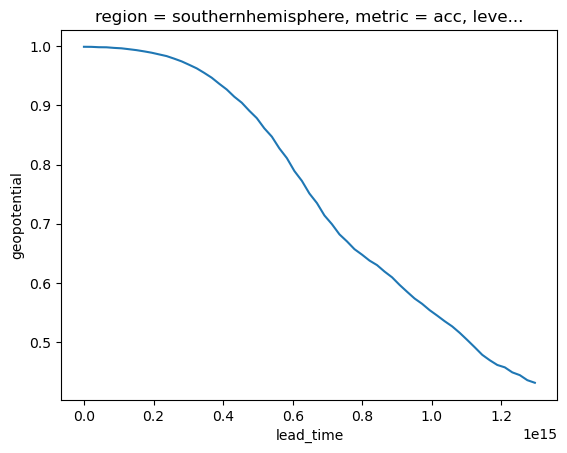

In [78]:
results['geopotential'].sel(metric='acc', level=850, region='southernhemisphere').plot()